# HallThruster.jl Tutorial

HallThruster is an efficient 1D fluid model to simulate Hall Thruster discharges. 
This tutorial will show you how to get started with HallThruster.jl and will compare our results to the Landmark study. The tutorial is also available as an [interactive Jupyter notebook](https://nbviewer.org/github/UM-PEPL/HallThruster.jl/blob/main/tutorials/HallThrusterTutorial.ipynb). Detailed information about the interface and internals of HallThruster.jl can be found in the [Documentation](https://um-pepl.github.io/HallThruster.jl/dev/).

First install HallThruster.jl according to the Readme instructions. Then load it:

In [28]:
using HallThruster

Let's also load Plots for visualization:

In [29]:
using Plots

# Landmark comparisons

Let's try and replicate the LANDMARK benchmarks. 

Let us define the function `run_landmark()` as a helper function. The most important arguments are `duration; ncells, nsave, dt`. When increasing the amount of cells, the timestep has to be reduced accordingly to satisfy the CFL condition. `nsave` specifies the amount of times the solution is saved in constant time intervals. 

Here we have the Landmark source terms and energy loss terms given as a standard, and we can select one of the 3 test cases to run. We initialize a new simulation and define the domain as twice the thruster length, as evident by the argument `domain = (0.0, 0.05)`. The default flux is set to `rusanov` and the time marching algorithm from DifferentialEquations.jl for the heavy species is a strong stability preserving Runge Kutta scheme of second order `SSPRK22`. 

In [9]:
function run_landmark(duration = 1e-3; ncells = 200, nsave = 2, dt = 0.7e-8, case = 1)

    domain = (0.0, 0.05)

    #Landmark cases loss frequencies
    αϵ_in, αϵ_out = if case == 1
        (1.0, 1.0)
    elseif case == 2
        (0.5, 1.0)
    elseif case == 3
        (0.4, 1.0)
    end

    scheme = HallThruster.HyperbolicScheme(
        flux_function = HallThruster.global_lax_friedrichs,
        limiter = HallThruster.minmod,
        reconstruct = true
    )

    ϵ_anode = 3.0
    ϵ_cathode = 3.0

    # Define the length over which the anomalous transport, wall collision frequency, and wall loss coefficients change
    transition_function = HallThruster.LinearTransition(1e-3, 0.0)

    config = HallThruster.Config(;
        ncharge = 1,
        anode_Te = 2/3 * ϵ_anode,
        cathode_Te = 2/3 * ϵ_cathode,
        discharge_voltage = 300.0,
        ionization_model = HallThruster.LandmarkIonizationLookup(),
        excitation_model = HallThruster.LandmarkExcitationLookup(),
        electron_neutral_model = HallThruster.LandmarkElectronNeutral(),
        electron_ion_collisions = false,
        wall_loss_model = HallThruster.ConstantSheathPotential(20, αϵ_in, αϵ_out),
        LANDMARK = true,
        neutral_velocity = 150.0,
        neutral_temperature = 0.0,
        ion_temperature = 0.0,
        thruster = HallThruster.SPT_100,
        anode_mass_flow_rate = 5e-6,
        scheme,
        domain,
        transition_function,
        electron_pressure_coupled = true,
        ion_wall_losses = false,
        anom_model = HallThruster.TwoZoneBohm(1/160, 1/16),
        anode_boundary_condition = :dirichlet,
    )

    @time sol = HallThruster.run_simulation(config; dt, duration, ncells, nsave)
    return sol
end

run_landmark (generic function with 2 methods)

Now we can use `run_landmark()` to perform simulations. For this first case, we need to use a small timestep because of instabilities.

In [20]:
sol_case1 = run_landmark(1e-3; ncells=100, nsave=10000, case = 1, dt = 0.05e-8)

195.977530 seconds (5.72 M allocations: 790.726 MiB, 0.16% gc time)


Hall thruster solution with 10000 saved frames
Retcode: success
End time: 0.001 seconds

`sol_case_1` is a `Solution` object. This mimics a standard DifferentialEquations `ODESolution` object and has the following fields
- `t`: The times at which the solution was saved
- `u`: A vector of solution matrices of length `nsave`. This contains the main state variables: $\rho_n$, $\rho_i$, $\rho_i u_i$, and $n_e\epsilon$
- `savevals`: A vector of NamedTuples containing some auxilliary variables including $\phi$, $n_e$, $T_{ev}$, $\nu_{AN}$ , $\nu_{en}$, $\nu_{ei}$, and $\mu$
- `retcode`: A short symbol describing how the solution ended. Generally this should be `:success`.
- `params`: The params that the simulation was run with.

HallThruster has some built-in plotting and postprocessing faculties. First, if we have `Plots` loaded, we can type `plot(sol, frame)` to plot the solution at the given frame (an `Int` from `1:nsave`). Leaving out `frame` will plot the last frame by default.

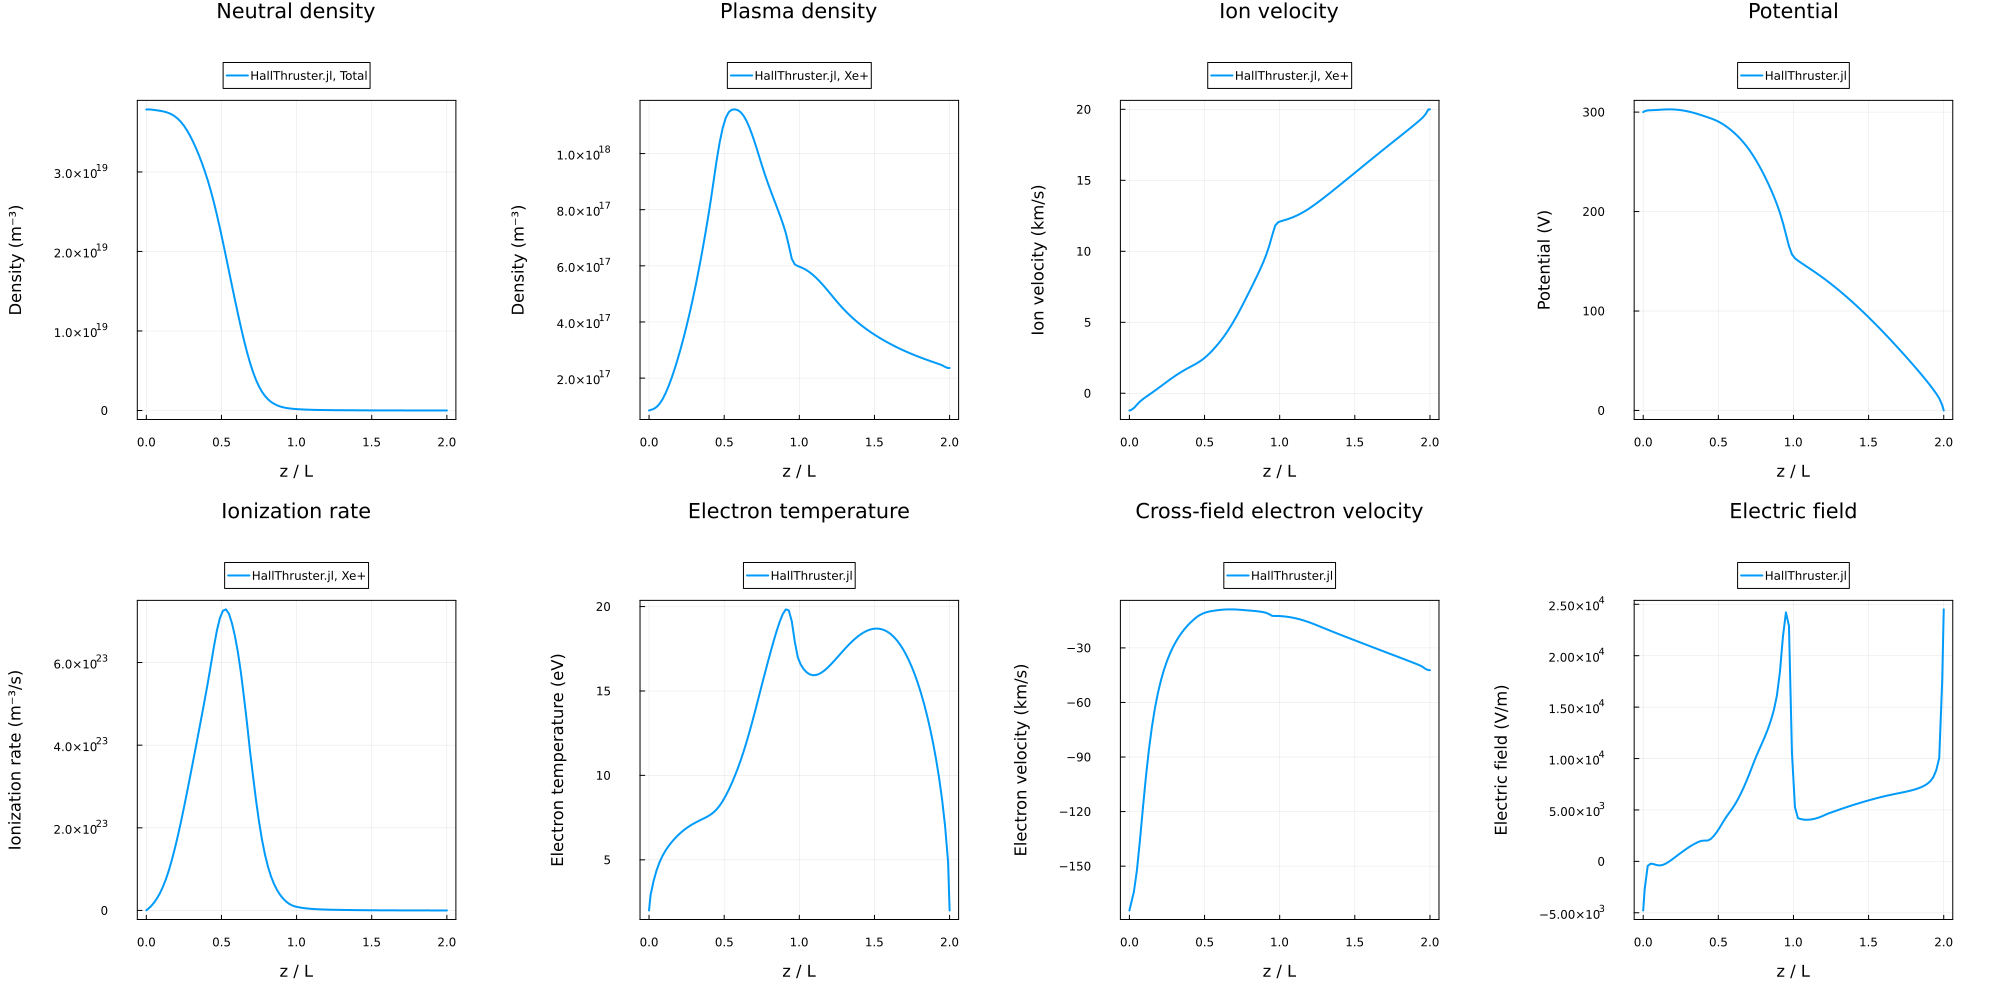

In [21]:
 plot(sol_case1, label = "HallThruster.jl", legend = :outertop)

We can load in the LANDMARK data for comparison:

In [22]:
landmark_1, landmark_2, landmark_hybrid = HallThruster.load_landmark_data(1);

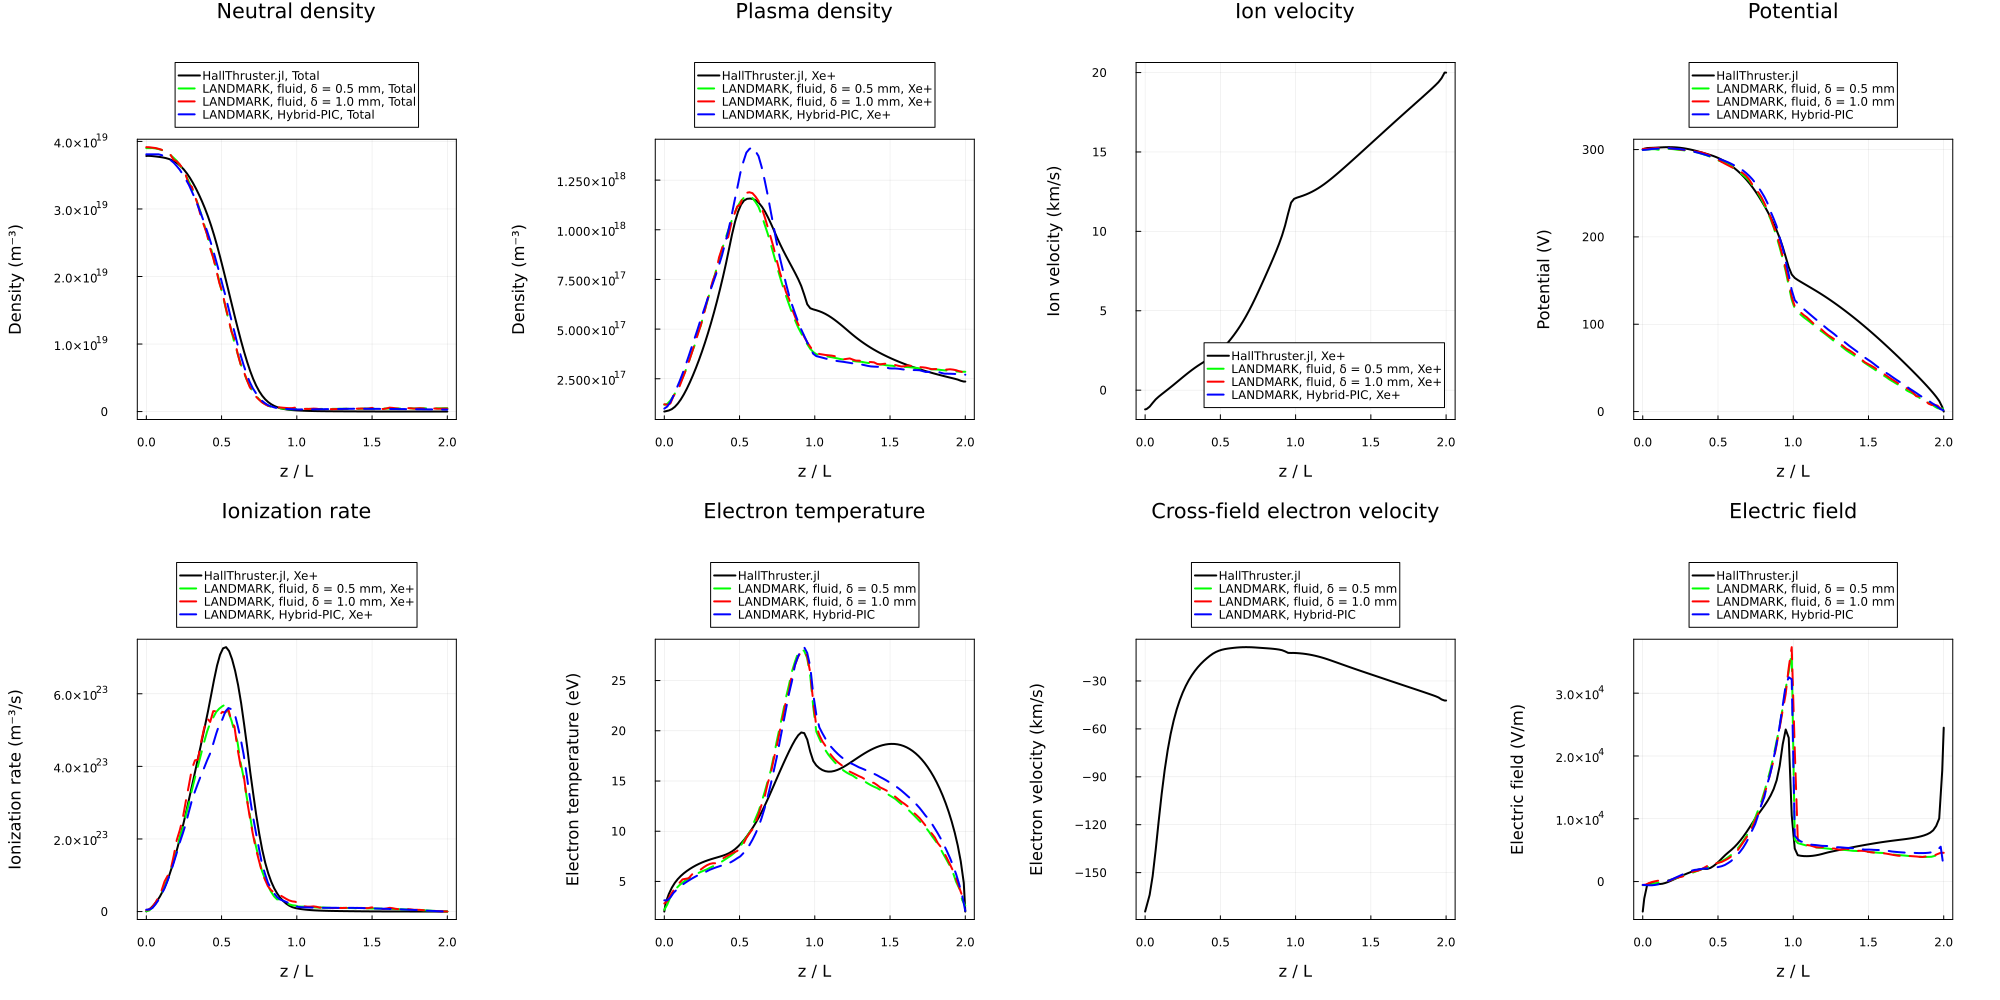

In [23]:
function compare_to_landmark(sol, case)
    p = plot(sol, label = "HallThruster.jl", legend = :outertop, lc = :black)

    landmark_1, landmark_2, landmark_hybrid = HallThruster.load_landmark_data(case)
    plot!(p, landmark_1, ls = :dash, lc = RGB(0.0, 1.0, 0.0), label = "LANDMARK, fluid, δ = 0.5 mm")
    plot!(p, landmark_2, ls = :dash, lc = RGB(1.0, 0.0, 0.0), label = "LANDMARK, fluid, δ = 1.0 mm")
    plot!(p, landmark_hybrid, ls = :dash, lc = RGB(0.0, 0.0, 1.0), label = "LANDMARK, Hybrid-PIC")
    return p
end

compare_to_landmark(sol_case1, 1)

This is a bit off from the benchmark. . However, Hall thrusters are strongly oscillatory devices, and we only plotted the last frame. Let's look instead at the time averaged behavior. For this, we use the `time_average` function, which returns another `Solution` object, and plot that against landmark

In [30]:
avg_case1 = time_average(sol_case1)
compare_to_landmark(avg_case1, 1)

BoundsError: BoundsError: attempt to access 0-element Vector{Vector{Float64}} at index [1]

This looks better. There are discrepancies due to minor differences in physics model and choice of numerics, but overall the agreement is good. We can also check the other LANDMARK cases. Below is the time-averaged behavior of case 2:

 34.869608 seconds (903.79 k allocations: 679.290 MiB, 0.69% gc time)


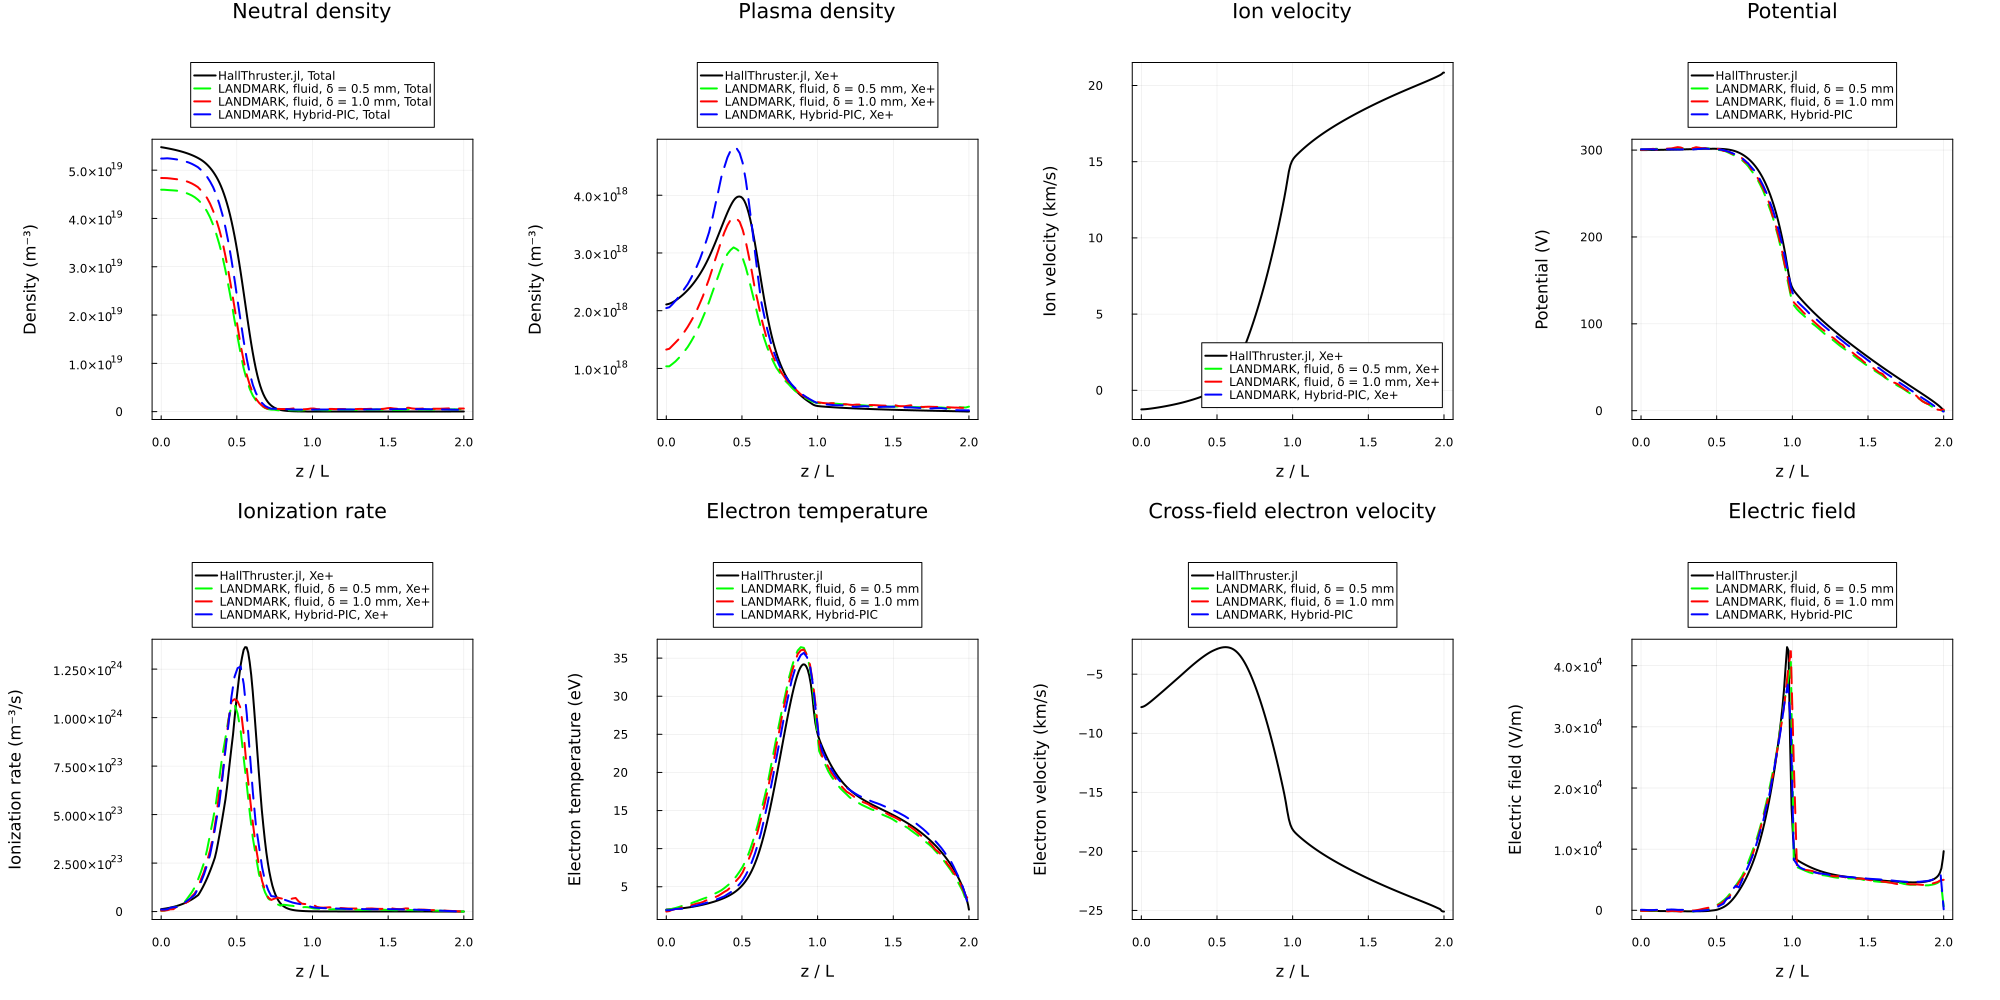

In [9]:
sol_case2 = run_landmark(1e-3; ncells=200, nsave=10000, case = 2, dt = 0.6e-8)
avg_case2 = time_average(sol_case2)
compare_to_landmark(avg_case2, 2)

And case 3: 

 32.746551 seconds (903.79 k allocations: 679.290 MiB, 0.40% gc time)


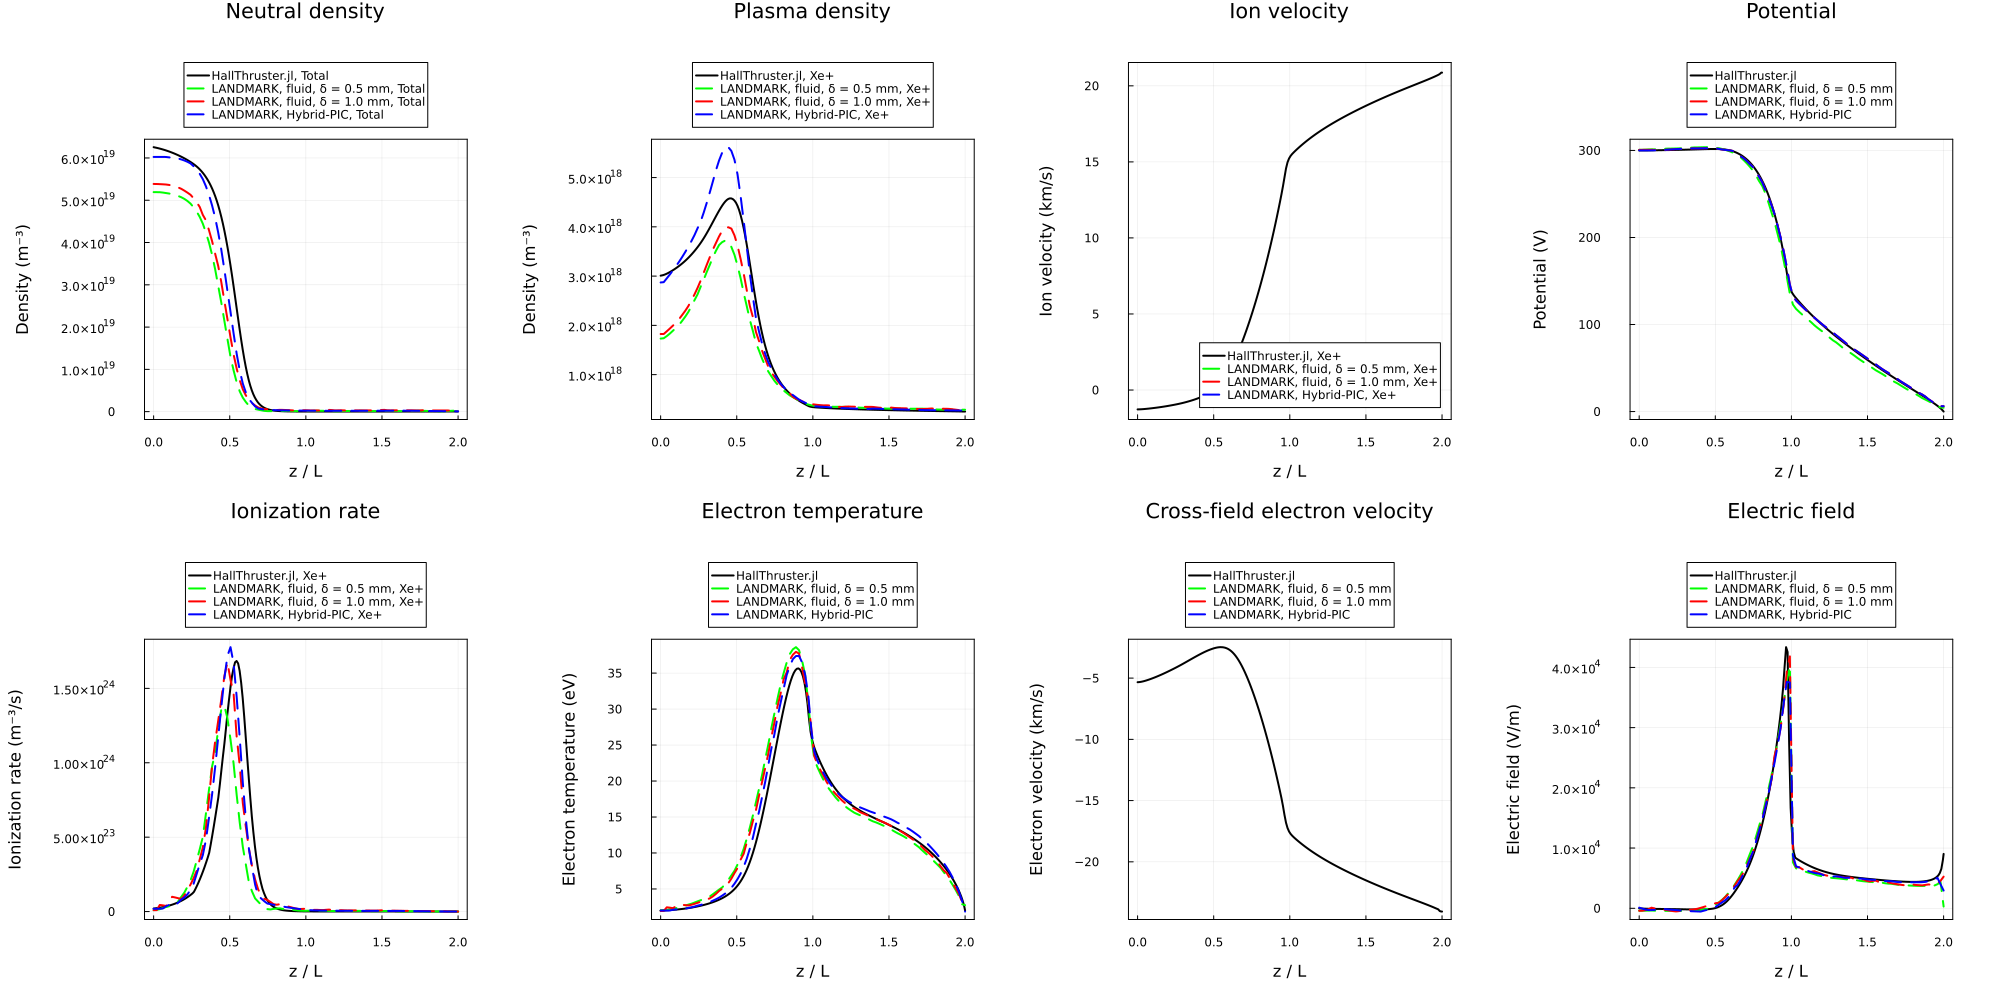

In [10]:
sol_case3 = run_landmark(1e-3; ncells=200, nsave=10000, case = 3, dt = 0.6e-8)
avg_case3 = time_average(sol_case3)
compare_to_landmark(avg_case3, 3)

## Built-in postprocessing tools

Here we will show how to extract thrust, current and other useful quantities from a simulation. The discharge current is computed during each timestep of a simulation, and we can extract and plot it as follows

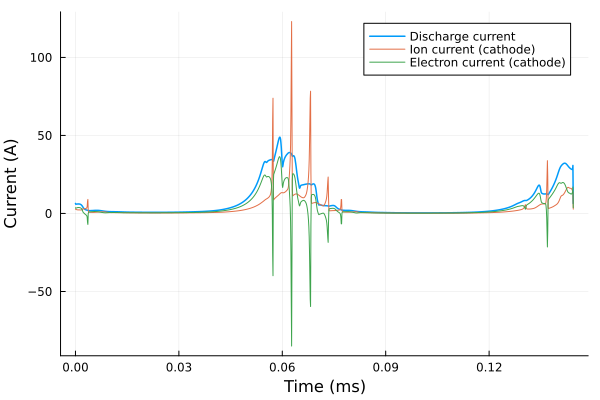

In [11]:
function plot_current(sol)
    (;A_ch, index, config) = sol.params
    e = HallThruster.e
    mi = config.propellant.m
    t_ms = sol.t * 1000 # convert from seconds to milliseconds
    N = length(t_ms)

    current = zeros(N)
    ion_current = zeros(N)
    electron_current = zeros(N)

    # Compute current densities at right boundary
    for i in eachindex(t_ms)

        current[i] = sol.savevals[i].Id[]
        ion_current[i] = e / mi * sol.u[i][index.ρiui[1], end]
        electron_current[i] = -e * sol.savevals[i].ne[end] * sol.savevals[i].ue[end]
    end

    # Multiply by channel area to get currents from current densities
    ion_current .*= A_ch
    electron_current .*= A_ch

    p = plot(t_ms, current, label = "Discharge current", xlabel = "Time (ms)", ylabel = "Current (A)", linewidth = 1.5)
    plot!(p, t_ms, ion_current, label = "Ion current (cathode)")
    plot!(p, t_ms, electron_current, label = "Electron current (cathode)")
    return p
end

plot_current(sol_case1)

As suspected, this case was quite oscillatory. We can see both transit-time oscillations (O(100 kHz)) in addition to the normal O(10 kHz) breathing mode oscillations, with intense transient spikes in both ion and electron currents.

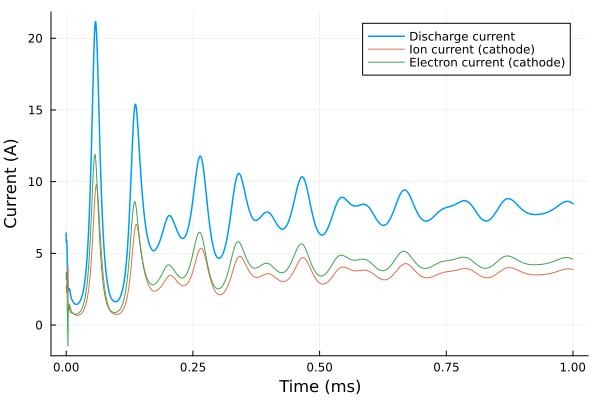

In [34]:
plot_current(sol_case2)

This case is more quiescent--we see small breathing oscillations with no transit time oscillations.

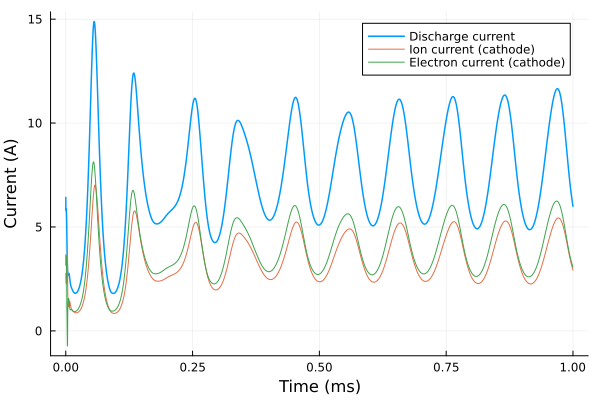

In [12]:
plot_current(sol_case3)

In case 3, we find large coherent breathing oscillations emerge, again with no transit time oscillations.

We can also compute the thrust (in Newtons) as a function of time.

## Extracting data from the `Solution` object

Let us take a closer look at the `Solution` object and how to extract data. HallThruster.jl provides a convienient interface to access plasma parameters from the solution object. If we index the `Solution` by a symbol, HallThruster will pull out a `Vector` of `Vector`s containing the evolution of that variable over time. To access the neutral density at the last timestep and the z position of the corresponding values we would type

In [37]:
nn_end = sol_case2[:nn][end]
z = sol_case1.params.z_cell
plot(z, nn_end, xlabel = "z (m)", ylabel = "Number Density (m^-3)", title = "Neutral density, case 2", label = "")

Similarly, we can get the ion velocity profile at the 4440th saved frame:

In [38]:
frame = 4440
ui = sol_case2[:ui][frame]
plot(z, ui, xlabel = "z (m)", ylabel = "Velocity (m/s)", label = "", title = "Ion velocity, frame $(frame), case 2")


If we have multiple charge states, we would need to index by [:ui, 1]. The same goes for ion number density. To get the density of the 3rd charge state we would index by [:ni, 3].

To get the potential, we index by `:ϕ`.

In [39]:
ϕ = sol_case2[:ϕ][end]
plot(z, ϕ, xlabel = "z (m)", ylabel = "Potential (V)", label = "", title = "Potential, case 2.")

This interface supports the following variables:

```:ne, :nn, :ni, :νan, :νen, :νei, :νex, :νiz, :νc, :νe, :Tev, :pe, :ui, :ϕ, :∇ϕ, :∇pe, :B, :ωce, :Id```

We can also inspect parameters that the simulation was run with and do not change over time. These are accesssible in `sol.params`. 
These are:

```julia
ncharge,
config,
ϕ_L,
ϕ_R,
Te_L,
Te_R,
L_ch,
A_ch,
z_cell,
z_edge,
dt,
progress_bar,
index, cache, fluids, fluid_ranges, species_range_dict,
iteration,
ionization_reactions,
ionization_reactant_indices,
ionization_product_indices,
excitation_reactions,
excitation_reactant_indices,
electron_neutral_collisions
```

Where `config` contains even more parameters and settings. You are referred to the [Configuration](https://um-pepl.github.io/HallThruster.jl/dev/config/) page of the documentation for a detailed description. 
As an example, let us extract the anomalous collision frequency model from the Landmark case 1 simulation. 



In [40]:
anom_model = sol_case1.params.config.anom_model

HallThruster.TwoZoneBohm((0.00625, 0.0625))

This returns a `TwoZoneBohm` object, which defines the anomalous collision frequency used in the Landmark cases. Anomalous collision frequency models in HallThruster.jl are explained [here](https://um-pepl.github.io/HallThruster.jl/dev/anomalous_transport/).

Let us plot the anomalous collision frequency vs axial position. 

In [41]:
νan = zeros(length(z))
anom_model(νan, sol_case2.params) # Mutating function
plot(
    z, νan,
    yaxis = :log, label = "Anomalous collision frequency", ylabel = "Frequency (Hz)", xlabel = "z (m)"
)
plot!(z, sol_case2[:ωce][end], label = "Cyclotron frequency", legend = :outertop)

One final feature: we export a recipe for plotting all relevant electron collision frequencies against each other. This takes a solution object and optionally a frame as arguments, as well as all typical Plots.jl args and keyword args.

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\thoma\.julia\packages\Plots\nqFaB\src\utils.jl:106


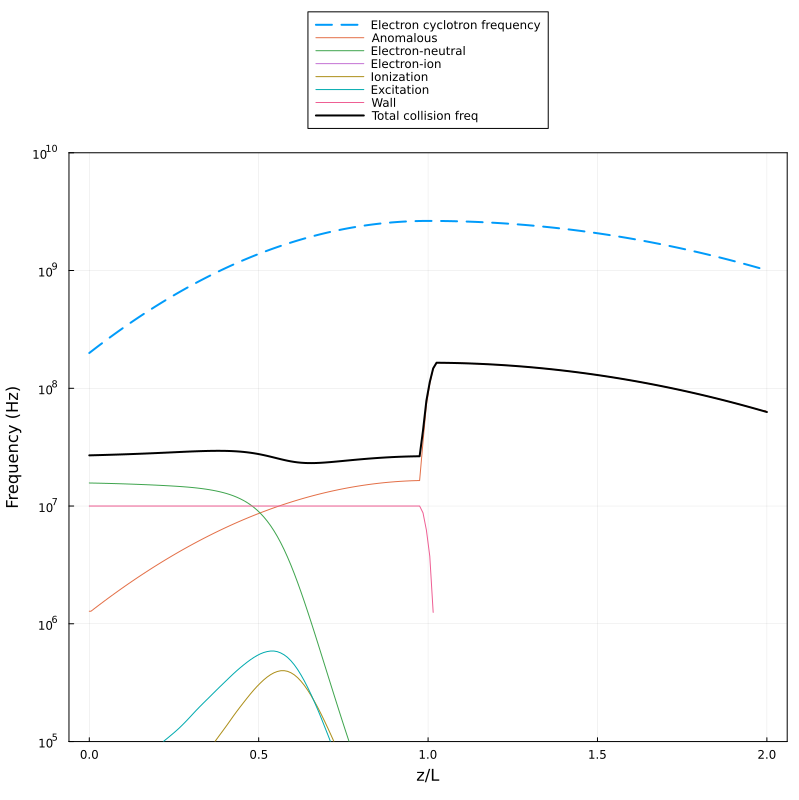

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\thoma\.julia\packages\Plots\nqFaB\src\utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\thoma\.julia\packages\Plots\nqFaB\src\utils.jl:106


In [42]:
collisionplot(time_average(sol_case3), size = (800, 800))

If you want to use other numerical fluxes, change the physics through collisions, boundary conditions, wall sheath losses, define new thrusters and change the domain length, use another propellant or provide your own source terms and ionization models, check out the Configuration section of the official [Documentation](https://um-pepl.github.io/HallThruster.jl/dev/.)